<a href="https://colab.research.google.com/github/akshatamadavi/cmpe258-assignment-3/blob/main/%5Bcolab_d%5Dnonlinear_regression_lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3-Layer DNN for Nonlinear Regression — PyTorch Lightning
Clean, boilerplate-free version using `LightningModule` and `Trainer`.

In [1]:
!pip install lightning -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.6/853.6 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 27.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import lightning as L
import matplotlib.pyplot as plt

## 1. Generate Nonlinear Data

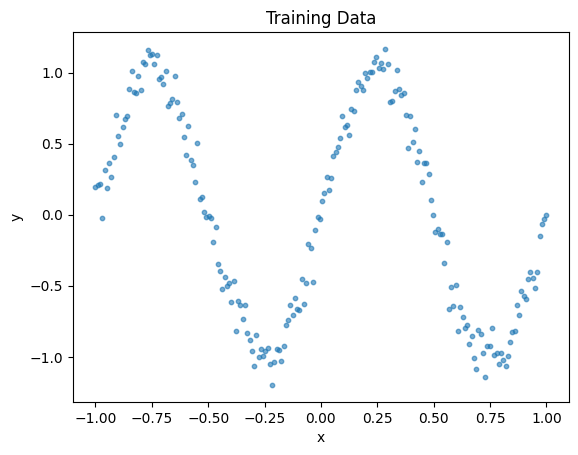

In [3]:
torch.manual_seed(42)

X = torch.linspace(-1, 1, 200).unsqueeze(1)          # (200, 1)
y = torch.sin(2 * torch.pi * X) + 0.1 * torch.randn_like(X)

dataset    = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

plt.scatter(X.numpy(), y.numpy(), s=10, alpha=0.6)
plt.title('Training Data'); plt.xlabel('x'); plt.ylabel('y')
plt.show()

## 2. Define the LightningModule
`LightningModule` replaces the manual train loop — you just define:
- `forward` → model architecture
- `training_step` → loss computation (Lightning calls `backward` + `optimizer.step` automatically)
- `configure_optimizers` → which optimizer to use

In [4]:
class RegressionNet(L.LightningModule):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()   # logs hparams automatically

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)   # 3rd layer → output
        )
        self.criterion = nn.MSELoss()

    # ── forward pass ──────────────────────────────────────────────────────────
    def forward(self, x):
        return self.net(x)

    # ── training step (Lightning handles zero_grad / backward / step) ─────────
    def training_step(self, batch, batch_idx):
        x, y     = batch
        y_pred   = self(x)
        loss     = self.criterion(y_pred, y)
        self.log('train_loss', loss, prog_bar=True)   # auto logged to progress bar
        return loss

    # ── optimizer ─────────────────────────────────────────────────────────────
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

## 3. Train with Lightning Trainer

In [5]:
model   = RegressionNet()
trainer = L.Trainer(
    max_epochs=200,
    enable_progress_bar=True,
    log_every_n_steps=10
)

trainer.fit(model, dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch

┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ net       │ Sequential │  4.4 K │ train │     0 │
│ 1 │ criterion │ MSELoss    │      0 │ train │     0 │
└───┴───────────┴────────────┴────────┴───────┴───────┘

Trainable params: 4.4 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.4 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 7                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:317: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


## 4. Plot Predictions

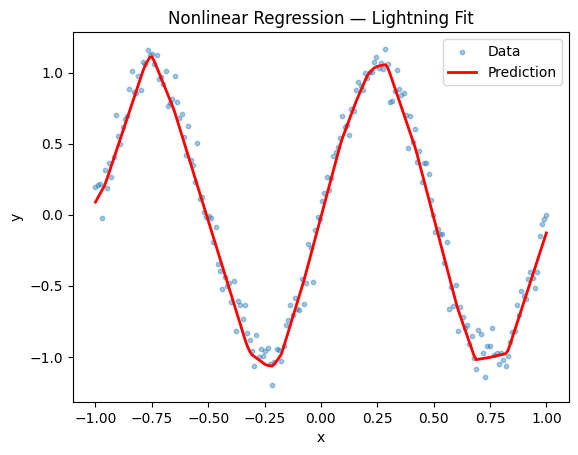

In [6]:
model.eval()
with torch.no_grad():
    y_pred = model(X)

plt.scatter(X.numpy(), y.numpy(), s=10, alpha=0.4, label='Data')
plt.plot(X.numpy(), y_pred.numpy(), color='red', linewidth=2, label='Prediction')
plt.title('Nonlinear Regression — Lightning Fit')
plt.xlabel('x'); plt.ylabel('y'); plt.legend()
plt.show()

## 5. Plot Training Loss from Logs

In [7]:
# Lightning saves metrics in trainer.logged_metrics or via CSVLogger
# Quick way: read from the default lightning_logs CSV
import pandas as pd, glob

csv_files = glob.glob('lightning_logs/version_*/metrics.csv')
if csv_files:
    metrics = pd.read_csv(sorted(csv_files)[-1])
    loss_data = metrics['train_loss'].dropna()
    plt.plot(loss_data.values)
    plt.title('Training Loss'); plt.xlabel('Step'); plt.ylabel('MSE')
    plt.yscale('log'); plt.show()
else:
    print('No CSV log found — run trainer.fit first.')

No CSV log found — run trainer.fit first.
